In [2]:
#import the needed Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import glob
import tensorflow as tf
from lxml import etree
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten
from keras.models import Sequential
from sklearn.model_selection import train_test_split

In [ ]:
#model version
__version__ = 0.1

In [ ]:
IMAGE_SIZE = 200

In [ ]:
def resizeannotation(f):
    tree = etree.parse(f)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text)/(width/IMAGE_SIZE)
        ymin = int(dim.xpath("ymin")[0].text)/(height/IMAGE_SIZE)
        xmax = int(dim.xpath("xmax")[0].text)/(width/IMAGE_SIZE)
        ymax = int(dim.xpath("ymax")[0].text)/(height/IMAGE_SIZE)
    return [int(xmax), int(ymax), int(xmin), int(ymin)]

In [ ]:
# DATASET = https://www.kaggle.com/datasets/andrewmvd/car-plate-detection

In [4]:
img_dir = r"archive\images" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
files.sort() #We sort the images in alphabetical order to match them to the xml files containing the annotations of the bounding boxes
X=[]
for f1 in files:
    img = cv2.imread(f1)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    X.append(np.array(img))
path = r'archive\annotations'
text_files = ['archive\\annotations\\'+f for f in sorted(os.listdir(path))]
y=[]
for i in text_files:
    y.append(resizeannotation(i))

In [5]:
X = np.array(X)
y = np.array(y)

In [6]:
X.shape,y.shape

(433, 200, 200, 3)

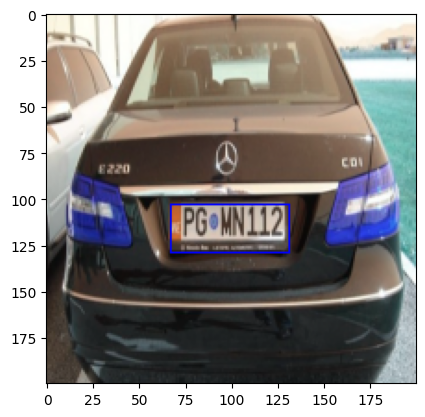

In [12]:
#Showing the annotations on sample image
image = cv2.rectangle(X[1],(y[1][0],y[1][1]),(y[1][2],y[1][3]),(0, 0, 255))
plt.imshow(image)
plt.show()

In [13]:
#Normalizing Logits and labels
X = X / 255
y = y / 255

In [15]:
#Spliting Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

In [42]:
# Create the model
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()

In [43]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [44]:
#Training on CUDA
with tf.device('/gpu:0'):
    train = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1,validation_split=0.2)

Epoch 1/50
10/10 [==============================] - 4s 280ms/step - loss: 0.2129 - accuracy: 0.4437 - val_loss: 0.2411 - val_accuracy: 0.4231
Epoch 2/50
10/10 [==============================] - 3s 263ms/step - loss: 0.2372 - accuracy: 0.4823 - val_loss: 0.2411 - val_accuracy: 0.4231
Epoch 3/50
10/10 [==============================] - 3s 263ms/step - loss: 0.2372 - accuracy: 0.4823 - val_loss: 0.2411 - val_accuracy: 0.4231
Epoch 4/50
10/10 [==============================] - 3s 263ms/step - loss: 0.2372 - accuracy: 0.4823 - val_loss: 0.2411 - val_accuracy: 0.4231
Epoch 5/50
10/10 [==============================] - 3s 263ms/step - loss: 0.2372 - accuracy: 0.4823 - val_loss: 0.2411 - val_accuracy: 0.4231
Epoch 6/50
10/10 [==============================] - 3s 263ms/step - loss: 0.2372 - accuracy: 0.4823 - val_loss: 0.2411 - val_accuracy: 0.4231
Epoch 7/50
10/10 [==============================] - 3s 264ms/step - loss: 0.2372 - accuracy: 0.4823 - val_loss: 0.2411 - val_accuracy: 0.4231
Epoch 

In [22]:
#evaluating Model
model.evaluate(X_test,y_test)

2/2 [==============================] - 3s 2s/step - loss: 0.0044 - accuracy: 0.8409


[0.004350969567894936, 0.8409090638160706]

In [28]:
#model.save('try.h5')
#model = tf.keras.models.load_model('try.h5')

In [29]:
#testing function for custom images
def tests(img):
    img = cv2.resize(img,(IMAGE_SIZE,IMAGE_SIZE))
    img = img / 255
    img = np.reshape(img,(1,IMAGE_SIZE,IMAGE_SIZE,3))
    y = model.predict(img)
    y = y*255
    img = np.reshape(img,(IMAGE_SIZE,IMAGE_SIZE,3))
    a = [int(x) for x in y[0]]
    print(a)
    image = cv2.rectangle(img,(int(y[0][0]),int(y[0][1])),(int(y[0][2]),int(y[0][3])),(0, 0, 255))
    plt.imshow(image)
    plt.show()
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[128, 141, 64, 116]


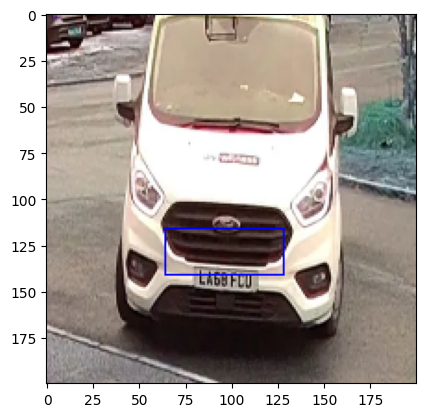

In [31]:
img = cv2.imread(r"C:\...Test\non_lpr_day_colour.webp")
tests(img)